# STEP 1: Exploratory Data Analysis

In the EDA step, we will explore our data and preparing them for training our model. The dataframe consists of 2 columns:

- **ImgPath:** Which is the path to our image file
- **Class:** Which is the type of our furniture image. It can either be beds, chairs, sofas, dressers, lamps, or tables.

To further optimize our data during the EDA process, we will try to detect the data for duplicated images to prevent overfitting and maintaining data consistency. Furthermore, it is also essential to ensure that our data is balanced for further improving our model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import os
import cv2
from joblib import dump, load

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score
from sklearn.preprocessing import PowerTransformer, PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from scipy.stats import skew
from joblib import dump, load
# import tensorflow as tf

#### GPU Optimization
Since we are dealing with large datasets as images, in order to train our model at a higher pace, we will optimize our running time of execution by running them via GPU not CPU.

In [2]:
import subprocess

def get_gpu_details():
    try:
        result = subprocess.run(['nvidia-smi'], capture_output=True)
        output = result.stdout.decode('utf-8')
        print(output)
    except FileNotFoundError:
        print("nvidia-smi not found. Please make sure NVIDIA drivers are installed.")

# Call the function to display GPU details
get_gpu_details()

Tue May  7 23:26:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.67                 Driver Version: 536.67       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   52C    P8               5W /  51W |    235MiB /  4096MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 1. From Raw Data to CSV
### Load Dataset

In [134]:
# dir_raw_dataset = r'../MyDrive/RMIT/machine learning/Asm2/Furniture_Data'
dir_raw_dataset = 'data/Furniture_Data'
main_folder_path = dir_raw_dataset

In [135]:
# List all sub-folders in the main folder
sub_folders = [sub_folder for sub_folder in os.listdir(main_folder_path) if os.path.isdir(os.path.join(main_folder_path, sub_folder))]
print(sub_folders)

['beds', 'chairs', 'dressers', 'lamps', 'sofas', 'tables']


### FurnitureData to csv
In order to save the FurnitureData folder data into a csv file, we will first load the folder path and save them into a column called 'ImgPath', the type of the image will be identified with a second column called 'Class'

### Load images from FurnitureData Folder

In [8]:
def load_csv(dataset_folder, label, prompt = ""):
    # Folder path containing the images
    folder_path = dataset_folder  # Replace with the actual folder path

    # List all files in the folder
    file_list = os.listdir(folder_path)
    data_csv = []
    for file_name in file_list:
        # Construct the full file path
        file_path = os.path.join(folder_path, file_name)
        # print(file_path)
        if os.path.isfile(file_path):
            data_csv.append([file_path, label])
    return data_csv

In [137]:
csv_data = []
for sub_folder in sub_folders:
      print("Accessing folder " + sub_folder)
      sub_folder_path = os.path.join(main_folder_path, sub_folder)
      # print(sub_folder_path)
      category_folders = [category_folder for category_folder in os.listdir(sub_folder_path) if os.path.isdir(os.path.join(sub_folder_path, category_folder))]
      # print(category_folders)
      for category_folder in category_folders:
        category_folder_path = os.path.join(sub_folder_path, category_folder)
        # print(category_folder_path)
        datas = load_csv(category_folder_path, sub_folder)
        csv_data.extend(datas)

print('Load succesffuly')


Accessing folder beds
Accessing folder chairs
Accessing folder dressers
Accessing folder lamps
Accessing folder sofas
Accessing folder tables
Load succesffuly


### Writing FurnitureData images data to a csv file

In [138]:
# Specify the file path and mode (e.g., 'w' for writing)

import os
import csv

file_path = 'data/data_raw.csv'

# Check if the directory exists
directory = os.path.dirname(file_path)
if not os.path.exists(directory):
    os.makedirs(directory)  # Create the directory if it does not exist

# Check if the file exists
if not os.path.isfile(file_path):
    with open(file_path, 'w') as file:
        file.write('')  # Create the file if it does not exist


# Open the CSV file in write mode and create a CSV writer object

with open(file_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(["ImgPath", "Class"])

    # Write the data to the CSV file row by row
    for row in csv_data:
        writer.writerow(row)
        
print('Data has been written to the CSV file.')

Data has been written to the CSV file.


### Read Data from csv
After writing the images data to a csv file we will now use the csv file to further explore our datasets

In [141]:
# Load the dataset for Exploratory Data Analysis purpose
data_eda = pd.read_csv('./data/data_raw.csv')

# # Replace each class number into a furniture type
# for id, category in enumerate(sub_folders):
#     data_eda['Class'] = data_eda['Class'].replace(id, category)

# data_eda.rename(columns = {"Class": "Type"}, inplace = True)

print(data_eda) # Print the data frame
data_eda.info()

                                                 ImgPath   Class
0      data/Furniture_Data\beds\Asian\19726asian-dayb...    beds
1      data/Furniture_Data\beds\Asian\20027asian-cano...    beds
2      data/Furniture_Data\beds\Asian\20109asian-pane...    beds
3      data/Furniture_Data\beds\Asian\20508asian-plat...    beds
4      data/Furniture_Data\beds\Asian\20750asian-comf...    beds
...                                                  ...     ...
90078  data/Furniture_Data\tables\Victorian\5victoria...  tables
90079  data/Furniture_Data\tables\Victorian\6victoria...  tables
90080  data/Furniture_Data\tables\Victorian\7victoria...  tables
90081  data/Furniture_Data\tables\Victorian\8victoria...  tables
90082  data/Furniture_Data\tables\Victorian\9victoria...  tables

[90083 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90083 entries, 0 to 90082
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ImgPath

## 2. Dataset Overview
### 2.1. Plotting graphs for overview

C:\Users\LENOVO\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


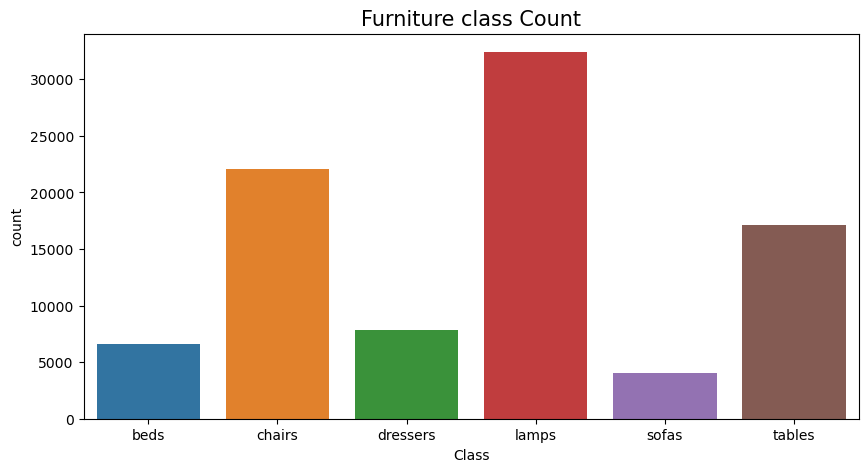

lamps       32401
chairs      22053
tables      17100
dressers     7871
beds         6578
sofas        4080
Name: Class, dtype: int64

In [147]:
# Plot bar graph
import seaborn as sns
plt.figure(figsize = (10, 5))
sns.countplot(data_eda['Class'])
plt.title("Furniture class Count", fontsize = 15)
plt.show()

data_eda['Class'].value_counts()

In [148]:
df_raw = pd.read_csv('./data/data_raw.csv')
df_raw.head()

,ImgPath,Class
0,data/Furniture_Data\beds\Asian\19726asian-dayb...,beds
1,data/Furniture_Data\beds\Asian\20027asian-cano...,beds
2,data/Furniture_Data\beds\Asian\20109asian-pane...,beds
3,data/Furniture_Data\beds\Asian\20508asian-plat...,beds
4,data/Furniture_Data\beds\Asian\20750asian-comf...,beds


### 2.2. Duplicated Images Checking
To check for the duplicated images we will use imagehash function with the column of focus is 'ImgPath'

In [149]:
import os
from PIL import Image
import imagehash

image_hashes = {}
duplicates_count = 0

for i, row in df_raw.iterrows():
    img_path = row["ImgPath"]
    try:
        with Image.open(img_path) as im:
            img_hash = imagehash.phash(im)
            if img_hash in image_hashes:
                image_hashes[img_hash].append(row["ImgPath"])
                duplicates_count += 1
            else:
                image_hashes[img_hash] = [img_path]
    except IOError as e:
        print(f"Error opening {img_path}: {e}")
    except PermissionError as e:
        print(f"Permission error with {img_path}: {e}")


In [151]:
duplicated_image_hashes = {hash_val: paths for hash_val, paths in image_hashes.items() if len(paths) > 1}  # Remove hashes with a single path
print(f'Number of duplicated images: {duplicates_count}')
print(len(duplicated_image_hashes))

Number of duplicated images: 10645
8748


Number of duplicated images: 10645
8748


In [152]:
def get_last_three_path(full_path):
    # Normalize the path to avoid issues with different OS path separators
    normalized_path = os.path.normpath(full_path)
    
    # Split the path into parts
    path_parts = normalized_path.split(os.sep)
    
    # Get the last three components of the path
    last_three_parts = os.sep.join(path_parts[-3:])
    
    return last_three_parts

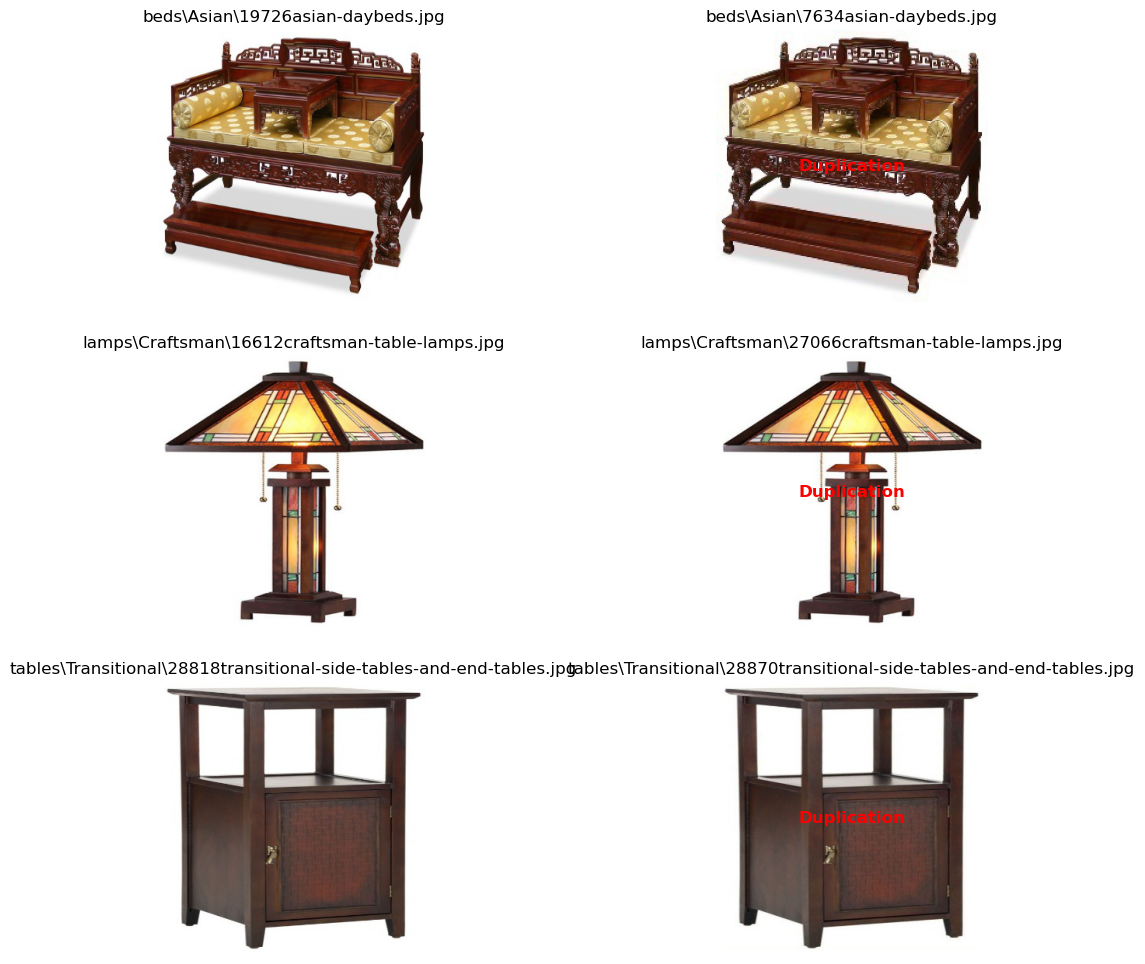

In [153]:
sample_indices = [0, len(duplicated_image_hashes.values()) // 2, len(duplicated_image_hashes.values()) - 1]

fig, ax = plt.subplots(3, 2, figsize=(12, 12))

for iteration, sample_index in enumerate(sample_indices):
    paths = list(duplicated_image_hashes.values())[sample_index]
    for i, path in enumerate(paths):
        if i >= 2:
            break

        im = Image.open(f'{path}')
        ax[iteration, i].imshow(im)
        if i > 0:
            ax[iteration, i].text(
                0.5, 0.5, f'Duplication',
                horizontalalignment='center',
                verticalalignment='center',
                transform=ax[iteration, i].transAxes,
                fontsize=12,
                color='red',
                weight='bold'
            )
        title_path = get_last_three_path(path)
        ax[iteration, i].set_title(title_path, fontsize=12)
        ax[iteration, i].axis('off')

plt.subplots_adjust(wspace=0.5, hspace=0.2)
plt.show()

In [1]:
# print(duplicated_image_hashes.values())

### 2.3. Removing Duplicates
We will drop all the duplicate images and save them to a new csv file called 'df_clean.csv'

In [154]:
# remove duplicated images
df_clean = df_raw.copy()
# Paths to remove
paths_to_remove = list(duplicated_image_hashes.values())
images_to_remove = [sublist[0] for sublist in paths_to_remove if len(sublist) > 0]

# Filter the DataFrame
df_filtered = df_clean[~df_clean['ImgPath'].isin(images_to_remove)]

# Resetting the index
df_clean = df_filtered.reset_index(drop=True)
df_clean.to_csv("./data/df_clean.csv", index=False)

# Output the filtered DataFrame
print(df_clean)

                                                 ImgPath   Class
0      data/Furniture_Data\beds\Asian\20027asian-cano...    beds
1      data/Furniture_Data\beds\Asian\20109asian-pane...    beds
2      data/Furniture_Data\beds\Asian\2537asian-platf...    beds
3      data/Furniture_Data\beds\Asian\2637asian-platf...    beds
4      data/Furniture_Data\beds\Asian\2709asian-platf...    beds
...                                                  ...     ...
81330  data/Furniture_Data\tables\Victorian\5victoria...  tables
81331  data/Furniture_Data\tables\Victorian\6victoria...  tables
81332  data/Furniture_Data\tables\Victorian\7victoria...  tables
81333  data/Furniture_Data\tables\Victorian\8victoria...  tables
81334  data/Furniture_Data\tables\Victorian\9victoria...  tables

[81335 rows x 2 columns]


## 3. Train Test Split
In this process, we will split our data into train_validation set and validation set. After that the train_validation set will be further split into a train set and a validation set. The reason for these split steps is to ensure that there are distinct datasets for training, testing, and validation purposes. This method will help us in assessing and optimizing data and model's perfomance while ensure that it generalizing well with unseen data.

In [155]:
#Split data
df_clean = pd.read_csv('./data/df_clean.csv')

df_X = df_clean.drop('Class', axis = 1)
df_Y = df_clean['Class']

# split data 60% train, 20% val, %20 test
train_val_X, test_X, train_val_Y, test_Y = train_test_split( df_X, df_Y, shuffle=True, test_size=0.2, random_state=42)
train_X, val_X, train_Y, val_Y = train_test_split( train_val_X, train_val_Y, shuffle=True, test_size=0.25, random_state=42)

print(f"train_X shape: {train_X.shape}")
print(f"train_Y shape: {train_Y.shape}")
print(f"val_X shape: {val_X.shape}")
print(f"val_Y shape: {val_Y.shape}")
print(f"test_X shape: {val_X.shape}")
print(f"test_Y shape: {val_Y.shape}")

train_X shape: (48801, 1)
train_Y shape: (48801,)
val_X shape: (16267, 1)
val_Y shape: (16267,)
test_X shape: (16267, 1)
test_Y shape: (16267,)


After that, we will save each split to a specific csv file.

In [156]:
# Save to csv
train_X.to_csv("./data/X_train_before_transformed.csv", index=False)
train_Y.to_csv("./data/Y_train_before_transformed.csv", index=False)
val_X.to_csv("./data/X_val.csv", index=False)
val_Y.to_csv("./data/Y_val.csv", index=False)
test_X.to_csv("./data/X_test.csv", index=False)
test_Y.to_csv("./data/Y_test.csv", index=False)

#### 3.1 Plotting figures after removing duplicates and splitting

C:\Users\LENOVO\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


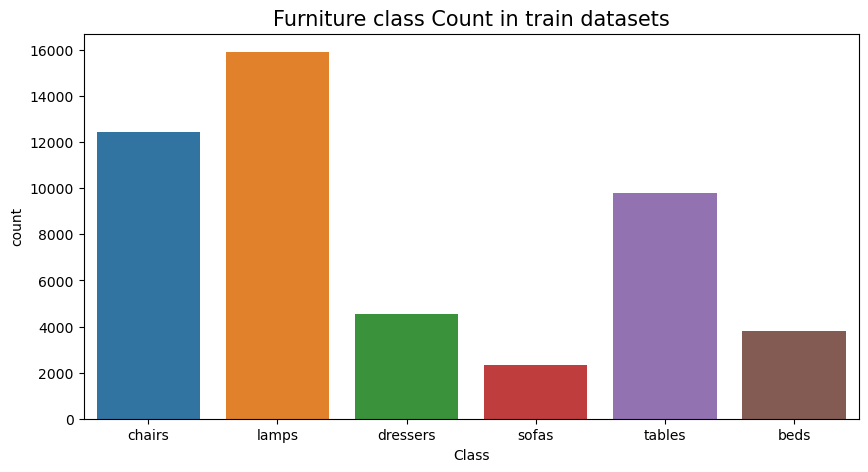

lamps       15907
chairs      12432
tables       9811
dressers     4543
beds         3798
sofas        2310
Name: Class, dtype: int64

In [157]:
# Plot bar graph
import seaborn as sns
plt.figure(figsize = (10, 5))
sns.countplot(train_Y)
plt.title("Furniture class Count in train datasets", fontsize = 15)
plt.show()

train_Y.value_counts()

In [123]:
train_Y.head()

15249    chairs
39291     lamps
23383    chairs
39899     lamps
48406     lamps
Name: Class, dtype: object

After removing the duplicates and splitting the data, we can see that there is still imbalance in our datasets. To further optimize our data during the EDA process, we will augmented our data on Data Augmentation step to handle the imbalance between classes.

# Data augmentation
**During the process, we will upsample the categories namely:**
- `sofas`
- `dressers and beds`

**And then downsample**

- `chairs`
- `lamps` 
- `tables`

In [4]:
import pandas as pd
import numpy as np
import os
from PIL import Image
import imgaug as ia
from imgaug import augmenters as iaa

**Reading the value from the dataset**

In [59]:
train_X_before_transformed = pd.read_csv('./data/X_train_before_transformed.csv')
train_Y_before_transformed = pd.read_csv('./data/Y_train_before_transformed.csv')
df_train_before_transformed = train_X_before_transformed.copy()
df_train_before_transformed['Class'] = train_Y_before_transformed

### Next, we will iterates over a list of external resources, loads data from CSV files corresponding to each resource, and aggregates all the loaded data into a single list external_csv.

In [60]:
external_resources = ['beds', 'sofas']
external_csv = []
exernal_path = 'external_resources'
for external_data in external_resources:
    print("Accessing folder " + external_data)
    folder_path = os.path.join(exernal_path, external_data)
    datas = load_csv(folder_path, external_data)
    external_csv.extend(datas)

print('Load external resources successfully')

Accessing folder beds
Accessing folder sofas
Load external resources successfully


In [71]:
df_external = pd.DataFrame(external_csv)
df_external.rename(columns = {0:'ImgPath', 1:'Class'}, inplace = True)
df_resources_added = pd.concat([df_train_before_transformed, df_external], ignore_index=True)
df_resources_added.to_csv('./data/df_added.csv', index = False)
df_resources_added.head()

,ImgPath,Class
0,data/Furniture_Data\chairs\Traditional\11591tr...,chairs
1,data/Furniture_Data\lamps\Contemporary\2750con...,lamps
2,data/Furniture_Data\chairs\Transitional\22967t...,chairs
3,data/Furniture_Data\lamps\Contemporary\33conte...,lamps
4,data/Furniture_Data\lamps\Contemporary\902cont...,lamps


Moving on, we will define an **augmentation function**
to applies several transformations to the:
- `input images`
- `including flips`
- `crops`
- `blurs`
- `contrast adjustments`
- `multiplicative color changes`
- `affine transformations`

Afterwards, it will augmenting the dataset to enhance the robustness and generalization of machine learning models trained on it.

In [29]:
def create_augmentation_sequence():
    return iaa.Sequential([
        iaa.Fliplr(0.5),  # horizontal flips
        iaa.Crop(percent=(0, 0.1)),  # random crops
        iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.5))),
        iaa.LinearContrast((0.75, 1.5)),
        iaa.Multiply((0.8, 1.2), per_channel=0.2),
        iaa.Affine(scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                   translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                   rotate=(-25, 25),
                   shear=(-8, 8))
    ])


**Going with that, the function takes a DataFrame with image data to conduct the process:**
- Filters it by category augments the images in that category 
- Save the augmented images to the output image path

In [ ]:
def augment_images(df, category, target_count=8000):
    # Filter DataFrame by category
    category_df = df[df['Class'] == category]
    current_count = len(category_df)
    seq = create_augmentation_sequence()

    output_dir = os.path.join('augmentation', category)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # While loop to keep generating until we reach the target count
    while current_count < target_count:
        for _, row in category_df.iterrows():
            img_path = row['ImgPath']
            try:
                image = Image.open(img_path)
                image_np = np.array(image)  # Convert to numpy array for augmentation
                augmented_image_np = seq(images=[image_np])[0] 
                augmented_image = Image.fromarray(augmented_image_np)
                augmented_image.save(os.path.join(output_dir, f"{os.path.splitext(os.path.basename(img_path))[0]}_aug_{current_count}.png"))
                current_count += 1
                if current_count >= target_count:
                    break
            except Exception as e:
                print(f"Failed to process {img_path}: {e}")

    return data


### Iterates over each category in the list and conduct image augmentation by utilizing the predefined function 

Our **purpose** is to enhance the `diversity` and `quantity` of images available for each category in the dataset.


In [39]:
categories = ['dressers', 'sofas', 'beds']
df_resources_added = pd.read_csv('./data/df_added.csv')
augmented_csv[]
for category in categories:
    augment_images(df_resources_added, category)

In [49]:
data_augmenation_csv = []
augmentation_path = 'augmentation'
for category in categories:
    print("Accessing folder " + category)
    folder_path = os.path.join(augmentation_path, category)
    datas = load_csv(folder_path, category)
    data_augmenation_csv.extend(datas)

print('Load augmentation data successfully')

Accessing folder dressers
Accessing folder sofas
Accessing folder beds
Load augmentation data successfully


### In addition, we will preprocesses the dataset
By **augmenting the data** then **combine** it with the raw dataset and balancing the classes to have **8000 samples each**, and then saving the final balanced dataset to a CSV file.

In [72]:
# Balance all classes to 8000 samples
df_augmentation = pd.DataFrame(data_augmenation_csv)
df_augmentation.rename(columns = {0:'ImgPath', 1:'Class'}, inplace = True)
df_resources_added = pd.read_csv('./data/df_added.csv')
df_sampling = pd.concat([df_resources_added, df_augmentation], ignore_index=True)
df_sampling.to_csv('./data/df_sampling.csv', index = False)

# Group by the category and then sample
df_final = df_sampling.groupby('Class').apply(lambda x: x.sample(min(len(x), 8000))).reset_index(drop=True)
df_final['Class'].value_counts()
df_final.to_csv('./data/df_final.csv')



### Ultimately, we will prepare the balanced dataset
By **separating** `features` and `labels` and saves them into respective CSV files.

In [74]:
X_train_final = df_final.drop('Class', axis = 1)
Y_train_final = df_final['Class']
X_train_final.to_csv('./data/X_train_final.csv', index = False)
Y_train_final.to_csv('./data/Y_train_final.csv', index = False)

**Visualizing the dataset by plotting**

C:\Users\LENOVO\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


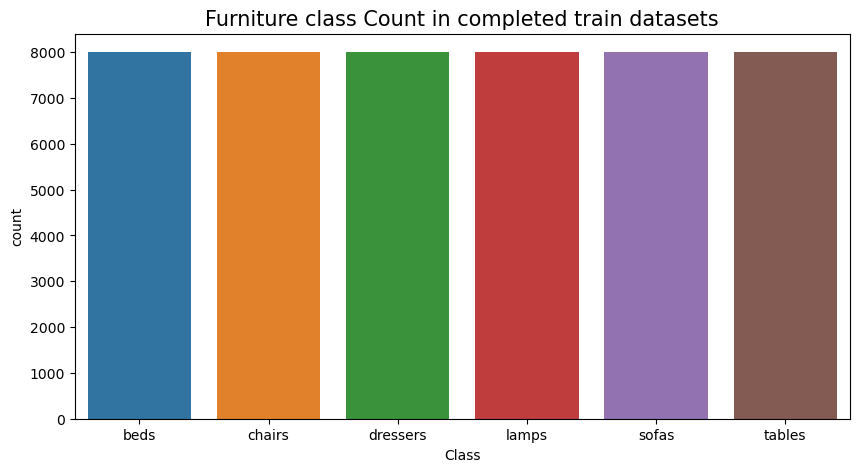

beds        8000
chairs      8000
dressers    8000
lamps       8000
sofas       8000
tables      8000
Name: Class, dtype: int64

In [76]:
# Plot bar graph
import seaborn as sns
plt.figure(figsize = (10, 5))
sns.countplot(Y_train_final)
plt.title("Furniture class Count in completed train datasets", fontsize = 15)
plt.show()
Y_train_final.value_counts()